# MATH50003 Numerical Analysis (2022–23)
# Lab 3: Divided differences and dual numbers

This lab explores different discretisations for first and higher derivatives.
In particular we consider the following approximations:
*Forward differences*:
$$
f'(x) ≈ {f(x+h) - f(x) \over h}
$$
*Central differences*:
$$
f'(x) ≈ {f(x+h) - f(x-h) \over 2h}
$$
*Second order differences*:
$$
f''(x) ≈ {f(x+h) - 2f(x) + f(x-h) \over h^2}
$$
We also add to the implementation of `Dual` to enable
automatic differentiation with cos, sin, and division

In [36]:
using Plots, Test
# helper function to avoid trying to take logs of 0 in plots
# use in plots below
# Here COND ? EXPR1 : EXPR2
# is another way to write
# if COND
#     EXPR1
# else
#     EXPR2
# end
nanabs = x -> iszero(x) ? NaN : abs(x)

#185 (generic function with 1 method)

--------

**Problem 1** Implement central differences
for $f(x) = 1 + x + x^2$ and $g(x) = 1 + x/3 + x^2$, approximating the derivative at $x = 0$.
Plot the absolute errors for `h = 2.0 .^ (0:-1:-60)` and `h = 10.0 .^ (0:-1:-16)`.

Hint: the easiest way to do this is the copy the code from lectures/notes for forward differences,
and replace the line `f.(h) .- f(0) ./ h` with the equivalent for central differences.
Note that `f.(h)` is broadcast notation so creates a vector containing `[f(h[1]),…,f(h[end])]`.
Thus that expression creates a vector containing `[(f(h[1])-f(0))/h[1], …, (f(h[end])-f(0))/h[end]]`.

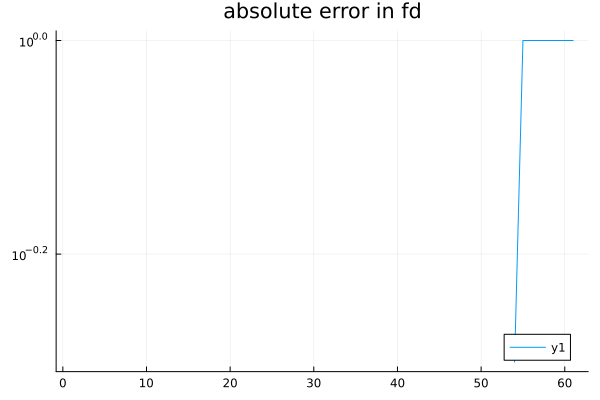

In [37]:
h = [10.0^k for k=0:-1:-16]
h = [2.0^k for k=0:-1:-60]
f = x -> 1 + x + x^2
f′ = x -> 1 + 2x
x = 0
fd = (f.(x .+ h) .- f.(x .- h))./(2 .* h)
plot(nanabs.(fd .- f′(x)); yscale=:log10, title="absolute error in fd")

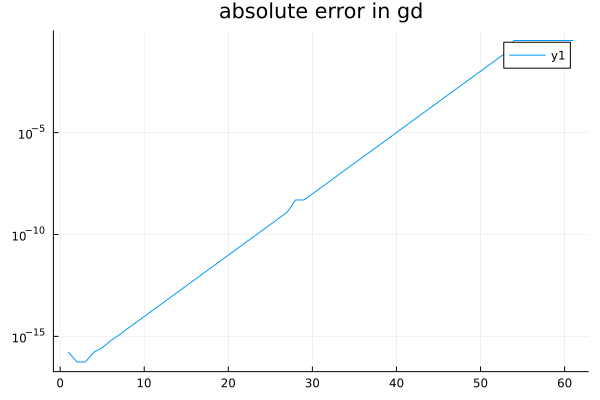

In [38]:
h = [10.0^k for k=0:-1:-16]
h = [2.0^k for k=0:-1:-60]
g = x -> 1 + x/3 + x^2
g′ = x -> 1/3 + 2x
x = 0
gd = (g.(x .+ h) .- g.(x .- h))./(2 .* h)
plot(nanabs.(gd .- g′(x)); yscale=:log10, title="absolute error in gd")

-----
**Problem 2** Use forward differences, central differences, and second-order divided differences to approximate to 5-digits the first and second
derivatives to the following functions
at the point $x = 0.1$:
$$
\exp(\exp x \cos x + \sin x), ∏_{k=1}^{1000} \left({x \over k}-1\right), \hbox{ and } f^{\rm s}_{1000}(x)
$$
where $f^{\rm s}_n(x)$ corresponds to $n$-terms of the following continued fraction:
$$
1 + {x-1 \over 2 + {x-1 \over 2 + {x-1 \over 2 + ⋱}}},
$$
e.g.:
$$f^{\rm s}_1(x) = 1 + {x-1 \over 2}$$
$$f^{\rm s}_2(x) = 1 + {x-1 \over 2 + {x -1 \over 2}}$$
$$f^{\rm s}_3(x) = 1 + {x-1 \over 2 + {x -1 \over 2 + {x-1 \over 2}}}$$

In [39]:
ex = x -> exp(exp(x) * cos(x) + sin(x))
function pr(x)
    result = 1
    for i = 1:1000
        result *= x/i - 1
    end
    result
end
fs = (x, n) -> n == 0 ? 0 : (x-1)/(2 + fs(x, n-1))
f = x -> fs(x, 1000)

x = 0.1
h = 2^(-10)

exdFoward = (ex(x + h) - ex(x))/h

h = 2^(-2)

exdCentral = (ex(x + h) - ex(x - h))/(2h)

6.653562426214696

----

We now extend our implementation of `Dual` which we began in lectures/notes as follows:

In [40]:
# Dual(a,b) represents a + b*ϵ
struct Dual{T}
    a::T
    b::T
end

# Dual(a) represents a + 0*ϵ
Dual(a::Real) = Dual(a, zero(a)) # for real numbers we use a + 0ϵ

# Allow for a + b*ϵ syntax
const ϵ = Dual(0, 1)

# import the functions which we wish to overload
import Base: +, *, -, /, ^, zero, exp, cos, sin, one

# support polynomials like 1 + x, x - 1, 2x or x*2 by reducing to Dual
+(x::Real, y::Dual) = Dual(x) + y
+(x::Dual, y::Real) = x + Dual(y)
-(x::Real, y::Dual) = Dual(x) - y
-(x::Dual, y::Real) = x - Dual(y)
*(x::Real, y::Dual) = Dual(x) * y
*(x::Dual, y::Real) = x * Dual(y)

# support x/2 (but not yet division of duals)
/(x::Dual, k::Real) = Dual(x.a/k, x.b/k)

# a simple recursive function to support x^2, x^3, etc.
function ^(x::Dual, k::Integer)
    if k < 0
        error("Not implemented")
    elseif k == 1
        x
    else
        x^(k-1) * x
    end
end

# support identity of type Dual
one(x::Dual) = Dual(one(eltype(x.a)))

# Algebraic operations for duals
-(x::Dual) = Dual(-x.a, -x.b)
+(x::Dual, y::Dual) = Dual(x.a + y.a, x.b + y.b)
-(x::Dual, y::Dual) = Dual(x.a - y.a, x.b - y.b)
*(x::Dual, y::Dual) = Dual(x.a*y.a, x.a*y.b + x.b*y.a)

exp(x::Dual) = Dual(exp(x.a), exp(x.a) * x.b)

exp (generic function with 16 methods)

**Problem 3.1** Add support for `cos`, `sin`, and `/` to the type `Dual`

In [41]:
# by replacing the `# TODO`s in the below code.

import Base.cos,Base.sin 

function cos(x::Dual)
    # TODO: implement cos for Duals
    Dual(cos(x.a), -sin(x.a) * x.b)
end

function sin(x::Dual)
    # TODO: implement sin for Duals
    Dual(sin(x.a), cos(x.a) * x.b)
end

function /(x::Dual, y::Dual)
    # TODO: implement division for Duals
    if iszero(y.a)
        error("Division for dual numbers is ill-defined when denonimator real part is zero.")
    end
    Dual(x.a / y.a, (x.b * y.a - x.a * y.b)/(y.a^2))
end

x = 0.1
@test cos(sin(x+ϵ)/(x+ϵ)).b ≈ -((cos(x)/x - sin(x)/x^2)sin(sin(x)/x))

Test Passed

**Problem 3.2** Use dual numbers to compute the derivatives to
$$
\exp(\exp x \cos x + \sin x), ∏_{k=1}^{1000} \left({x \over k}-1\right), \hbox{ and } f^{\rm s}_{1000}(x).
$$
Does your answer match (to 5 digits) Problem 2?

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*